# Kachelung von Bildern - der naive Ansatz
Bei der gekachelten Bildverarbeitung besteht der erste Schritt darin, das Bild in Kacheln zu zerschneiden. Während dies mit numpy gemacht werden könnte, werden wir [dask](https://docs.dask.org/en/stable/) verwenden, da es in diesem Zusammenhang mehrere sehr nützliche Funktionen mitbringt.

In [1]:
import dask
import dask.array as da
from skimage.filters import gaussian
from skimage.data import cells3d
from pyclesperanto_prototype import imshow

Im ersten Beispiel werden wir ein Bild verwenden, das Zellkerne aus der Fluoreszenzmikroskopie zeigt, und es einfach mit einem Gauß-Filter entrauschen. Wir werden dies Kachel für Kachel durchführen. Dafür definieren wir zunächst die `procedure`, die auf alle Kacheln angewendet werden soll. Wir bauen in diese Funktion eine print-Anweisung ein, um zu sehen, wann sie ausgeführt wird und wie groß das Bild ist, das verarbeitet wird.

In [2]:
def procedure(image):
    print("proceduring", image.shape)
    return gaussian(image, sigma=5)

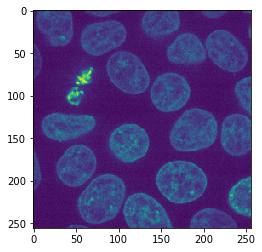

In [3]:
image = cells3d()[30,1]
imshow(image)

Nach dem Laden des Bildes kann es wie folgt gekachelt werden. In dask werden Kacheln auch als _chunks_ bezeichnet.

In [4]:
tiles = da.from_array(image, chunks=(128, 128))
tiles

dask.array<array, shape=(256, 256), dtype=uint16, chunksize=(128, 128), chunktype=numpy.ndarray>

Als Nächstes teilen wir dask mit, was mit unseren Kacheln geschehen soll. Wir wollen die Funktion `procedure` auf alle einzelnen Kacheln _mappen_. Beachten Sie, dass dies das gesamte Bild noch nicht verarbeitet.

In [5]:
tile_map = da.map_blocks(procedure, tiles)

proceduring (0, 0)
proceduring (1, 1)


Wie wir lesen können, wurde die Funktion zweimal mit sehr kleinen Bildern (0x0 und 1x1 Pixel) ausgeführt. Dask macht das prinzipiell, um zu erkunden, ob die Funktion funktioniert. Als Nächstes werden wir unsere `procedure` tatsächlich auf den Kacheln des Bildes ausführen.

In [6]:
result = tile_map.compute() # Warnung: Dies lädt alle Bilddaten in den Speicher

proceduringproceduring (128, 128)
 (128, 128)
proceduring (128, 128)
proceduring (128, 128)


Die gedruckte Ausgabe sieht etwas chaotisch aus, weil dask die `procedure` parallel auf mehreren Kacheln ausgeführt hat. Wenn wir das Ergebnis untersuchen, werden wir sehen, dass es wieder ein Bild ist.

In [7]:
result.shape

(256, 256)

In [8]:
type(result)

numpy.ndarray

**Hinweis:** Die `imshow`-Funktion funktioniert möglicherweise nicht bei großen Datensätzen. Wir verwenden sie hier zu Demonstrationszwecken.

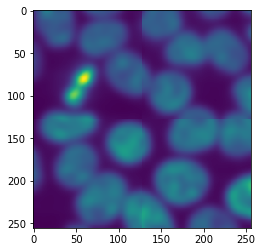

In [9]:
imshow(result)

## Randeffekte
Bei der Verarbeitung von Bildern Kachel für Kachel müssen wir immer davon ausgehen, dass entlang der Ränder Artefakte auftreten, die aus dem Zerschneiden des Bildes in Kacheln resultieren. Da unser Beispielbild in den Speicher passt, können wir `procedure` darauf anwenden und es mit dem Ergebnis der gekachelten Bildverarbeitung vergleichen.

proceduring (256, 256)


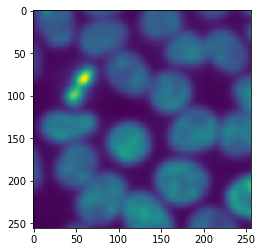

In [10]:
untiled_result = procedure(image)
imshow(untiled_result)

Die Unterschiede sind nicht offensichtlich, aber wir können sie visualisieren.

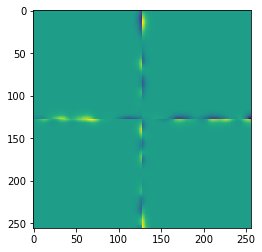

In [11]:
difference = result - untiled_result
imshow(difference)

Bei Anwendung eines Gauß-Filters mit einem kleinen Sigma können diese Effekte vernachlässigbar sein. Falls die Effekte schwerwiegende Probleme in unserem Bildverarbeitungs-Workflow verursachen, möchten wir diese Artefakte möglicherweise reduzieren oder sogar verhindern.